In [3]:
import numpy as np
from scipy.sparse import csr_matrix as sparse_mat
import pickle
import sys
from sklearn.cross_validation import train_test_split
import math

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# settings for plots
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

/Users/gaurang/Code/spring16/ABDA/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [1]:
# returns the non-zero entries from the sparse matrix
def non_zero(sparse_matrix):
    return np.transpose(sparse_matrix.nonzero())

## Loading Ratings Matrix Pickle

---
## Splitting the Dataset into Training, Validation and Testing Sets
##### Do Not Run This Everytime

- Training Set: 70%  
- Test Set: 30%  

In [31]:
training = []
testing = []
sample = []

for j, business in enumerate(ratings.T):
    indices = non_zero(business)
    indices = [[idx[1], j] for idx in indices]
    if len(indices) > 10:
        train, test = train_test_split(indices, test_size=0.3, random_state=42)
        training.extend(train)
        testing.extend(test)
        if np.random.uniform(low=0, high=1) <= 0.1:
            sample.extend(train)
    else:
        training.extend(indices)
        if np.random.uniform(low=0, high=1) <= 0.1:
            sample.extend(indices)

#### Saving split data into pickles, so that we can evaluate all models on the same training, validation and testing sets

In [32]:
training_sample, validation_sample = train_test_split(sample, test_size=0.3, random_state=42)

In [ ]:
pickle.dump(training, open('pickles/training_indices.p', 'wb'))
pickle.dump(testing, open('pickles/testing_indices.p', 'wb'))

In [40]:
pickle.dump(training_sample, open('pickles/training_samples.p', 'wb'))
pickle.dump(validation_sample, open('pickles/validation_samples.p', 'wb'))

---

### Load training, validation and testing data directly

In [8]:
training = pickle.load(open('pickles/training_indices.p', 'rb'))
testing = pickle.load(open('pickles/testing_indices.p', 'rb'))

#### Load the Ratings matrix

In [4]:
ratings = pickle.load(open('pickles/ratings_matrix.p', 'rb'))

##### Load the training and validation sample directly if required

In [13]:
training_sample = pickle.load(open('pickles/training_samples.p', 'rb'))
testing_sample = pickle.load(open('pickles/validation_samples.p', 'rb'))

## The Latent Factor Model, without considering reviews:

#### Batch Gradient Descent Approach:
Clearly, this is very slow, but it gives proper results.

In [5]:
def train_latent_factors(R, training_indices, k=2, eta=1e-2, lamb=1e-2, 
                         threshold=1e-5, iterations=250, stochastic=False, stocIter=10):
    m, n = R.shape
    U = np.random.uniform(-1, 1, (m, k))
    B = np.random.uniform(-1, 1, (n, k))
    i = 0
    prev = 0
    curr = sys.maxint
    T = len(training_indices)
    while i < iterations and abs(curr - prev) > threshold:
        prev = curr
        cost = 0
        for idx in training_indices:
            epsilon = R[idx[0], idx[1]] - np.dot(U[idx[0]], B[idx[1]].T)
            temp_U = U[idx[0], :] + eta * (epsilon * B[idx[1]] - lamb * U[idx[0], :])
            B[idx[1], :] = B[idx[1], :] + eta * (epsilon * U[idx[0]] - lamb * B[idx[1], :])
            U[idx[0], :] = temp_U
            cost += (R[idx[0], idx[1]] - np.dot(U[idx[0]], B[idx[1]].T )) ** 2 + \
                                    lamb * (np.linalg.norm(U[idx[0]])**2 + np.linalg.norm(B[idx[1]])**2)

        cost = math.sqrt(cost / T)
        if stochastic == True:
            print "Stochastic Training RMSE: ", cost
            if i == stocIter:
                break
        
        # 
        curr = cost
        print "RMSE:", curr
        i += 1
        
    # print "Total Iterations: ", i
    return U, B

#### Run for user, business and review loading directly

In [6]:
user_map = pickle.load(open('pickles/users_map.p', 'rb'))
business_map = pickle.load(open('pickles/business_map.p', 'rb'))
reviews = pickle.load(open('pickles/reviews.p', 'rb'))

#### Global and Individual Baselines have to be adjusted before training

In [6]:
baselines = pickle.load(open('pickles/baselines.p', 'rb'))
alpha = baselines['alpha']
beta_users = baselines['beta_users']
beta_business = baselines['beta_business']

In [8]:
# removing baselines from ratings data
for idx in non_zero(ratings):
    ratings[idx[0], idx[1]] -= (alpha + beta_users[idx[0]] + beta_business[idx[1]])

##### Train the model on the training set

In [19]:
U, B = train_latent_factors(ratings, training, k=10, iterations=50)

0.000850987737661
0.000715884893602
0.000621437228679
0.000551492144223
0.000497422119349
0.000454202038018
0.000418706776023
0.000388890672492
0.0003633590322
0.000341129454906
0.000321491573338
0.000303920778515
0.00028802302697
0.000273498307584
0.000260115728536
0.000247696077583
0.000236099327363
0.0002252154965
0.000214957840416
0.000205257693694
0.000196060506569
0.000187322761477
0.000179009550455
0.000171092657916
0.000163549036647
0.000156359594491
0.000149508229676
0.000142981066994
0.000136765857163
0.00013085150906
0.000125227730074
0.000119884754202
0.00011481314104
0.000110003631786
0.000105447050826
0.000101134243525
9.7056042538e-05
9.32032562931e-05
8.95666743826e-05
8.61370854656e-05
8.29053039624e-05
7.98622024088e-05
7.69987468342e-05
7.43060329834e-05
7.17753216215e-05
6.93980715571e-05
6.71659693821e-05
6.50709552622e-05
6.31052444006e-05
6.12613440465e-05
Total Iterations:  50


### Validate the model on a random sample of 10000 points:

- Sample the first 10% businesses from the total data.
- Split the sample into training and validation only (70 - 30)
- Train for range of $\lambda$, and compute errors on validation.
- The $\lambda$ with best error is saved and used for training the full dataset

The full data will be split into 70-30 train test

In [15]:
def predict(u_idx, b_idx, U, B):
    return np.dot(U[u_idx], B[b_idx].T)

In [16]:
def errors(test_set, U, B, ratings=ratings):
    error = 0
    for idx in test_set:
        u_idx = idx[0]
        b_idx = idx[1]
        error += (ratings[u_idx, b_idx] - predict(u_idx, b_idx, U, B)) ** 2
    return math.sqrt(error/len(test_set))

In [10]:
def validate(training_sample, validation_sample, ratings=ratings, start=0.005, end=0.02, steps=0.001):
    best_error = sys.maxint
    best_lambda = 0
    for lam in np.arange(start, end, steps):
        U, B = train_latent_factors(ratings, training_sample, k=10, iterations=50, lamb=lam)
        error = errors(validation_sample, U, B)
        if (error < best_error):
            best_error = error
            best_lambda = lam
    return best_lambda

In [33]:
best_lambda = validate(training_sample, validation_sample)

0.000929771713575
0.000809912206745
0.000708718656482
0.000622561279765
0.000548716003906
0.000485083173571
0.000430009823869
0.000382172020538
0.000340494044881
0.000304091203343
0.000272228339811
0.000244289101153
0.000219752754325
0.000198176421919
0.000179181278232
0.000162441686856
0.000147676553501
0.000134642367447
0.000123127544255
0.000112947781296
0.000103942209204
9.59701748288e-05
8.8908530197e-05
8.26493310739e-05
7.70978705598e-05
7.21709896033e-05
6.77956187136e-05
6.39075145106e-05
6.04501618533e-05
5.73738176816e-05
5.46346768657e-05
5.21941435786e-05
5.001819426e-05
4.80768202802e-05
4.63435400849e-05
4.47949719826e-05
4.34104599071e-05
4.21717454769e-05
4.10626805314e-05
4.00689750611e-05
3.91779760927e-05
3.83784736534e-05
3.76605304242e-05
3.70153321242e-05
3.64350560408e-05
3.59127554467e-05
3.54422579315e-05
3.50180759259e-05
3.46353279122e-05
3.42896690067e-05
Total Iterations:  50
0.000919286305693
0.000805145717077
0.000708137899161
0.000625072141376
0.0005535

In [17]:
best_lambda = 0.016

### Run the Latent Factors model for k = [1,2,5,8,10]

In [18]:
# train the model with final set of parameters
test_errors_latent_factors = []
min_err = sys.maxint
best_U = None
best_B = None
best_k = None
best_error = None
ks = [2,5,8,10, 12, 15]
for k in ks:
    U, B = train_latent_factors(ratings, training_sample, lamb=best_lambda, stochastic=False)
    error = errors(testing_sample, U, B)
    if error < min_err:
        best_k = k
        best_U = U
        best_B = B
        best_error = error
    test_errors_latent_factors.append(error)
    print "k:", k, "error:", error

RMSE: 1.158781082
RMSE: 1.12992516431
RMSE: 1.11343168999
RMSE: 1.10162286022
RMSE: 1.09230838126
RMSE: 1.08452400101
RMSE: 1.07775559923
RMSE: 1.07169581674
RMSE: 1.06614615919
RMSE: 1.06097103093
RMSE: 1.05607374124
RMSE: 1.05138297471
RMSE: 1.04684469606
RMSE: 1.04241707043
RMSE: 1.03806714797
RMSE: 1.03376862645
RMSE: 1.02950029696
RMSE: 1.02524493629
RMSE: 1.02098849901
RMSE: 1.01671951561
RMSE: 1.0124286349
RMSE: 1.00810826951
RMSE: 1.00375231604
RMSE: 0.999355930243
RMSE: 0.994915343338
RMSE: 0.990427709491
RMSE: 0.985890977334
RMSE: 0.981303780289
RMSE: 0.976665341912
RMSE: 0.9719753935
RMSE: 0.967234101952
RMSE: 0.96244200645
RMSE: 0.957599962902
RMSE: 0.952709095373
RMSE: 0.947770753864
RMSE: 0.94278647789
RMSE: 0.937757965342
RMSE: 0.932687046092
RMSE: 0.927575659839
RMSE: 0.922425837676
RMSE: 0.917239686927
RMSE: 0.912019378853
RMSE: 0.906767138919
RMSE: 0.901485239372
RMSE: 0.89617599395
RMSE: 0.890841754556
RMSE: 0.885484909681
RMSE: 0.880107884316
RMSE: 0.874713140933
RM

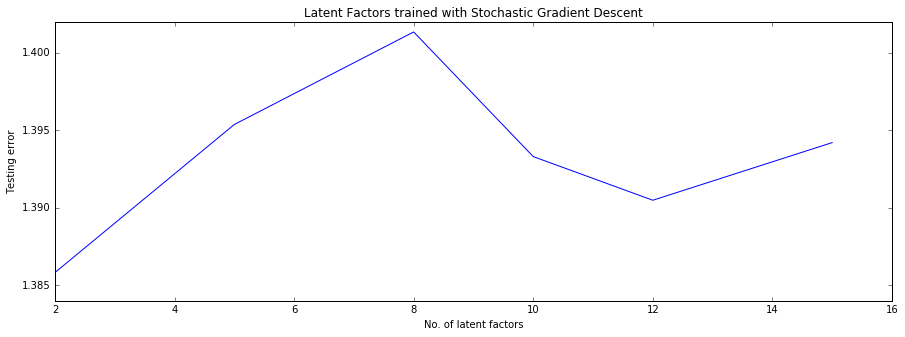

In [19]:
plt.plot(np.asarray(ks), np.asarray(test_errors_latent_factors))
plt.xlabel("No. of latent factors")
plt.ylabel("Testing error")
plt.title("Latent Factors trained with Stochastic Gradient Descent")

In [13]:
testing_errors_batch = []